# Cassiopeia Benchmarking Pipeline

Here, we simulate trees with ecDNA. Based on benchmark.ipynb 

"You can install Cassiopeia by following the guide [here](https://cassiopeia-lineage.readthedocs.io/en/latest/installation.html)."

"All of our documentation is hosted [here](https://cassiopeia-lineage.readthedocs.io/en/latest/)."

In [2]:
import cProfile
from collections import defaultdict
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
from tqdm.auto import tqdm

import cassiopeia as cas
from cassiopeia.solver import missing_data_methods

In [3]:
from IPython.display import Image


Here's where I recall python syntax / test code snippets

In [ ]:
np.inf

## Tree Simulation

ecDNABirthDeathSimulator is based on BirthDeathFitnesSimulator, which is documented [here](https://cassiopeia-lineage.readthedocs.io/en/latest/api/reference/cassiopeia.sim.BirthDeathFitnessSimulator.html). 

In [4]:
bd_sim = cas.sim.ecDNABirthDeathSimulator(
    birth_waiting_distribution = lambda scale: np.random.exponential(scale),
    initial_birth_scale = 0.5,
    death_waiting_distribution = lambda: np.inf, # lambda: np.random.exponential(1.5),
    # mutation_distribution = lambda: 1 if np.random.uniform() < 0.5 else 0,
    # fitness_distribution = lambda: np.random.normal(0, .5),
    # fitness_base = 1.3,
    num_extant = 4,
    random_seed=17, 
    initial_copy_number = np.array([7,3,5]),
    splitting_function = lambda x: np.random.binomial(x, p=0.5),
)
ground_truth_tree = bd_sim.simulate_tree()

current_lineages is empty




Let's stare manually at a few ecDNA CNs. One weird thing I'm noticing is that there isn't conservation of copy number right now. This could be b/c of death. so I'll re-run with infinite time to death.
I tried this and it still doesn't conserve CN, which is weird. 

I figured out why it doesn't conserve CN. It's because there's a weird passage of cell 0 to cell 1 before division is allowed to start occurring. Let's figure out where/why this happens and stop it. 

It happens in simulate_tree (inherited from BirthDeathSimulator), because in order to sample the first waiting time, we call sample_lineage_event. I fixed this in a really hack-y way (see ecDNABirthDeathSimulator.py, search for "TO DO" to see what I mean). No wait, this fix doesn't work; it seems liek the bypass is *always* being triggered. Let's stare at that and try to see why.

I didn't figure out why the other condition in sample_lineage_event didn't work, but this one (checking whether we're at time 0) does. So i'll go with it for now.

I manually checked that the ecDNA CN are doubling every generation (for two generations).


In [5]:
# ground_truth_tree.__dict__  
ground_truth_tree._CassiopeiaTree__network.__dict__

{'graph': {},
 '_node': {'0': {'birth_scale': 0.5,
   'time': 0,
   'ecdna_array': array([7, 3, 5]),
   'character_states': []},
  '1': {'birth_scale': 0.5,
   'time': 0.17454120776779053,
   'ecdna_array': array([7, 3, 5]),
   'character_states': []},
  '2': {'birth_scale': 0.5,
   'time': 0.5526770979578748,
   'ecdna_array': array([5, 1, 6]),
   'character_states': []},
  '3': {'birth_scale': 0.5,
   'time': 0.7085830237491872,
   'ecdna_array': array([9, 5, 4]),
   'character_states': []},
  '4': {'birth_scale': 0.5,
   'time': 0.7395444922982826,
   'ecdna_array': array([5, 0, 5]),
   'character_states': []},
  '5': {'birth_scale': 0.5,
   'time': 0.7395444922982826,
   'ecdna_array': array([5, 2, 7]),
   'character_states': []},
  '6': {'birth_scale': 0.5,
   'time': 0.7395444922982826,
   'ecdna_array': array([11,  7,  2]),
   'character_states': []},
  '7': {'birth_scale': 0.5,
   'time': 0.7395444922982826,
   'ecdna_array': array([7, 3, 6]),
   'character_states': []}},
 '_ad

We canNOT upload and export trees to iTOL (iTOL is no longer free). Instead, we can use the local visualization library. Learn more in local_plotting.ipynb. 

(<Figure size 504x504 with 1 Axes>, <AxesSubplot:>)

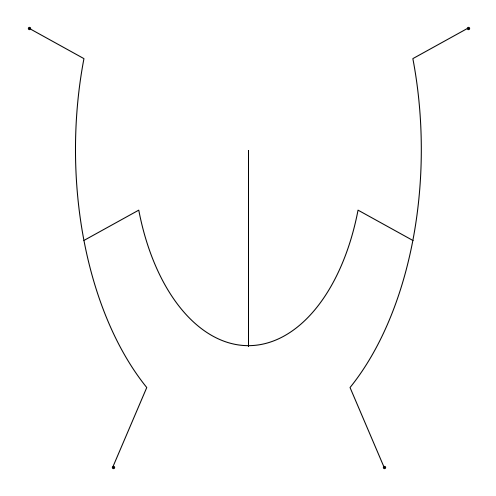

In [6]:
cas.pl.plot_matplotlib(ground_truth_tree, add_root=True)

Now, let's try to annotate the tree with the copy numbers.

## Overlay Lineage Tracing Data

We can then use our Cas9-based lineage tracing data simulator to overlay data. Here, this is a very flexible Cas9-data generator in which we can specify the dependence structure between characters (i.e. the cassettes that link togehter cut sites), the mutation rate, silencing rates, and state distributions. This function derives from the DataSimulator class & implements the `overlay_data` function which operates on a `CassiopeiaTree`, such as the one you simulated above. 

In [7]:
np.random.seed(seed=None)
lt_sim = cas.sim.Cas9LineageTracingDataSimulator(
    number_of_cassettes = 40,
    size_of_cassette = 1,
    mutation_rate = 0.1,
    state_generating_distribution = lambda: np.random.exponential(1e-5),
    number_of_states = 50,
    state_priors = None,
    heritable_silencing_rate = 9e-4,
    stochastic_silencing_rate = 0.1,
    heritable_missing_data_state = -1,
    stochastic_missing_data_state = -1,
)
lt_sim.overlay_data(ground_truth_tree)

We can get a feel for the character matrix and the complexity of the data here by extracting the simulated data.

We simulated 40 characters across 4 cells.


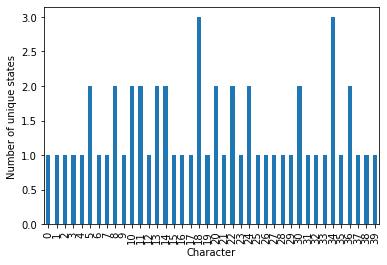

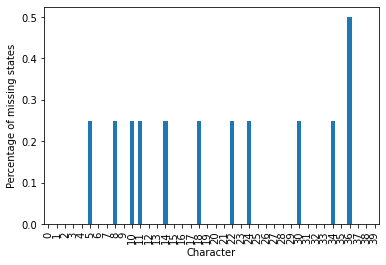

In [8]:
## inspect character matrix

character_matrix = ground_truth_tree.character_matrix

print(f"We simulated {character_matrix.shape[1]} characters across {character_matrix.shape[0]} cells.")

# plot the number of unique states per character
character_matrix.nunique(axis=0).plot(kind='bar')
plt.xlabel("Character")
plt.ylabel("Number of unique states ")
plt.show()

missing_data_per_character = character_matrix.apply(lambda x: len(x[x == -1]) / len(x), axis=0)
missing_data_per_character.plot(kind='bar')
plt.xlabel("Character")
plt.ylabel("Percentage of missing states")
plt.show()

## Rebuild trees

Cassiopeia has implemented several CassiopeiaSolvers for reconstructing trees. Each of these can take in several class-specific parameters and at a minimum implements the `solve` routine which operates on a CassiopeiaTree. 

The full list of solvers can be found [here](https://cassiopeia-lineage.readthedocs.io/en/latest/api/solver.html). For a full tutorial on tree reconstruction, refer to the [Tree Reconstruction notebook](https://github.com/YosefLab/Cassiopeia/blob/latest/notebooks/reconstruct.ipynb).

Here we use the VanillaGreedySolver, which was described in the [Cassiopeia paper published in 2020](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-02000-8).

In [9]:
reconstructed_tree = cas.data.CassiopeiaTree(character_matrix = ground_truth_tree.character_matrix, missing_state_indicator = -1)

greedy_solver = cas.solver.VanillaGreedySolver()
greedy_solver.solve(reconstructed_tree)


(<Figure size 504x504 with 1 Axes>, <AxesSubplot:>)

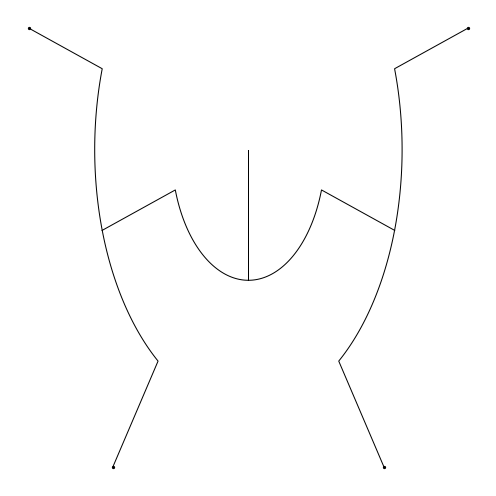

In [10]:
cas.pl.plot_matplotlib(reconstructed_tree, add_root=True)

## Critique

Our `critique` library is for testing the similarity between CassiopeiaTrees. The most pertinent use case is when comparing the reconstruction accuracy. We have two metrics implemented - a triplets correct measure, and the Robinson-Foulds metric.

In [11]:
reconstructed_tree.collapse_mutationless_edges(infer_ancestral_characters = True)

rf, rf_max = cas.critique.compare.robinson_foulds(ground_truth_tree, reconstructed_tree)

print(f"Normalized RF: {rf / rf_max}")

Normalized RF: 0.0


In [13]:
triplets = cas.critique.compare.triplets_correct(ground_truth_tree, reconstructed_tree, number_of_trials = 500)

(defaultdict(<class 'int'>, {0: 1.0}), defaultdict(<class 'int'>, {0: 1.0}), defaultdict(<class 'int'>, {0: 1.0}), defaultdict(<class 'int'>, {0: 0.0}))


## Building benchmarking pipelines

We can link all of these steps together to benchmark the performance of several algorithms.

The briefest of benchmarking pipelines would consist of:

- Simulating a ground truth phylogeny
- Overlaying data onto this phylogeny
- Inferring the phylogeny with potentially many algorithms
- Assessing performance

Here we show a very simple benchmarking pipeline:

In [14]:

algorithms = {"Vanilla Greedy": cas.solver.VanillaGreedySolver(),
              'UPGMA': cas.solver.UPGMASolver(dissimilarity_function=cas.solver.dissimilarity.weighted_hamming_distance),
              'NeighborJoining': cas.solver.NeighborJoiningSolver(dissimilarity_function=cas.solver.dissimilarity.weighted_hamming_distance, add_root=True)
             }

iterations = 10

algorithm_to_performance_triplets = defaultdict(list)
algorithm_to_performance_rf = defaultdict(list)
for _ in tqdm(range(iterations)):
    
    ground_truth_tree = bd_sim.simulate_tree()
    
    np.random.seed(None)
    lt_sim.overlay_data(ground_truth_tree)
    
    for algorithm_name in tqdm(algorithms.keys()):
        
        algorithm = algorithms[algorithm_name]
        
        reconstructed_tree = cas.data.CassiopeiaTree(character_matrix = ground_truth_tree.character_matrix, missing_state_indicator = -1)
        algorithm.solve(reconstructed_tree)
        
        # ground_truth_tree.collapse_mutationless_edges(infer_ancestral_characters = False)
        reconstructed_tree.collapse_mutationless_edges(infer_ancestral_characters = True)

        rf, rf_max = cas.critique.compare.robinson_foulds(ground_truth_tree, reconstructed_tree)
        
        triplets = cas.critique.compare.triplets_correct(ground_truth_tree, reconstructed_tree, number_of_trials=500)
        algorithm_to_performance_triplets[algorithm_name].append(np.mean(list(triplets[0].values())))
        
        algorithm_to_performance_rf[algorithm_name].append(rf / rf_max)

        
        
        

  0%|          | 0/10 [00:00<?, ?it/s]

current_lineages is empty




  0%|          | 0/3 [00:00<?, ?it/s]

current_lineages is empty




  0%|          | 0/3 [00:00<?, ?it/s]

current_lineages is empty




  0%|          | 0/3 [00:00<?, ?it/s]

current_lineages is empty




  0%|          | 0/3 [00:00<?, ?it/s]

current_lineages is empty




  0%|          | 0/3 [00:00<?, ?it/s]

current_lineages is empty




  0%|          | 0/3 [00:00<?, ?it/s]

current_lineages is empty




  0%|          | 0/3 [00:00<?, ?it/s]

current_lineages is empty




  0%|          | 0/3 [00:00<?, ?it/s]

current_lineages is empty




  0%|          | 0/3 [00:00<?, ?it/s]

current_lineages is empty




  0%|          | 0/3 [00:00<?, ?it/s]

We can easily visualize results after reformatting the dictionaries of performances

In [15]:
algorithm_to_performance_triplets_df = pd.DataFrame(columns = ['Algorithm', 'Triplets'])
for algorithm in algorithm_to_performance_triplets:
    
    entries = algorithm_to_performance_triplets[algorithm]
    new_df = pd.DataFrame([algorithm]*len(entries), columns = ['Algorithm'])
    new_df['Triplets'] = entries
    
    algorithm_to_performance_triplets_df = pd.concat([algorithm_to_performance_triplets_df, new_df])
    
algorithm_to_performance_rf_df = pd.DataFrame(columns = ['Algorithm', 'RF'])
for algorithm in algorithm_to_performance_rf:
    
    entries = algorithm_to_performance_rf[algorithm]
    new_df = pd.DataFrame([algorithm]*len(entries), columns = ['Algorithm'])
    new_df['RF'] = entries
    
    algorithm_to_performance_rf_df = pd.concat([algorithm_to_performance_rf_df, new_df])

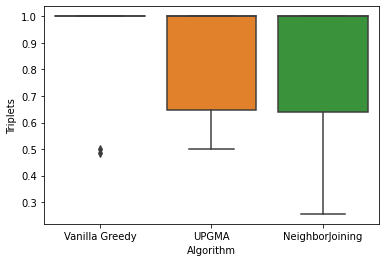

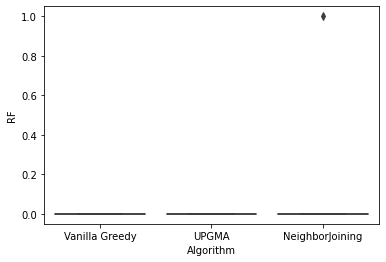

In [16]:
sns.boxplot(data=algorithm_to_performance_triplets_df, x = 'Algorithm', y = 'Triplets')
plt.show()

sns.boxplot(data=algorithm_to_performance_rf_df, x = 'Algorithm', y = 'RF')
plt.show()

In [17]:
print(algorithm_to_performance_triplets_df)

         Algorithm  Triplets
0   Vanilla Greedy     1.000
1   Vanilla Greedy     1.000
2   Vanilla Greedy     0.502
3   Vanilla Greedy     1.000
4   Vanilla Greedy     1.000
5   Vanilla Greedy     1.000
6   Vanilla Greedy     1.000
7   Vanilla Greedy     0.486
8   Vanilla Greedy     1.000
9   Vanilla Greedy     1.000
0            UPGMA     1.000
1            UPGMA     1.000
2            UPGMA     0.500
3            UPGMA     0.530
4            UPGMA     1.000
5            UPGMA     1.000
6            UPGMA     1.000
7            UPGMA     0.504
8            UPGMA     1.000
9            UPGMA     1.000
0  NeighborJoining     1.000
1  NeighborJoining     1.000
2  NeighborJoining     0.518
3  NeighborJoining     0.256
4  NeighborJoining     1.000
5  NeighborJoining     1.000
6  NeighborJoining     1.000
7  NeighborJoining     0.482
8  NeighborJoining     1.000
9  NeighborJoining     1.000
